In [1]:
import pandas as pd

In [2]:
df = pd.DataFrame()
df = pd.read_csv("train_proper_csv_attack_types.csv",header = None)
df = df.rename(columns=df.iloc[0])
df = df.drop(df.index[0])
df = df.drop('unknown2',axis=1)

C:\Users\Rupesh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df1 = pd.DataFrame()
df1 = pd.read_csv("test_proper_csv_attack_types.csv",header = None)
df1 = df1.rename(columns=df1.iloc[0])
df1 = df1.drop(df1.index[0])
df1 = df1.drop('unknown2',axis=1)

C:\Users\Rupesh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_tot = pd.concat([df,df1])

In [5]:
def bool_attack(x):
    if(x != "normal"):
        return "attack"
    else:
        return "normal"

In [12]:
from sklearn.feature_selection import SelectFpr
from sklearn.feature_selection import chi2
from sklearn.preprocessing import Normalizer

df_tot_1 = df_tot.drop('unknown1',axis=1)
df_output = df_tot['unknown1'].apply(bool_attack)
df_tot_dum = pd.get_dummies(df_tot_1,columns = ["protocol_type","service","flag"])
x_normalise = Normalizer().fit(df_tot_dum)
df_tot_dummies = x_normalise.transform(df_tot_dum)
sfpr = SelectFpr(chi2, alpha=0.05)
x_new = sfpr.fit_transform(df_tot_dummies, df_output)

In [14]:
df_tot_1.shape

(148516, 41)

In [15]:
len(list(df_tot_dum.columns[sfpr.get_support()]))

36

In [11]:
list(df_tot_dum.columns[sfpr.get_support()])

['src_bytes',
 'dst_bytes',
 'wrong_fragment',
 'logged_in',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'protocol_type_icmp',
 'protocol_type_tcp',
 'protocol_type_udp',
 'service_domain_u',
 'service_eco_i',
 'service_http',
 'service_imap4',
 'service_pop_3',
 'service_private',
 'service_telnet',
 'flag_REJ',
 'flag_RSTO',
 'flag_RSTR',
 'flag_S0',
 'flag_SH']

In [9]:
x_new.shape

(148516, 19)

In [17]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_tot_dummies, df_output, test_size=0.20, random_state=0)

In [10]:
X_train = x_new[:125000]
y_train = df_output.iloc[:125000]
X_test = x_new[125000:]
y_test = df_output.iloc[125000:]

In [11]:
import pickle

In [12]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [13]:
def cal_fpr_acc(TP,FP,TN,FN):
    acc = (TP+TN)/(TP+TN+FP+FN)
    fpr = (FP)/(FP+TN)
    
    return fpr, acc

In [14]:
def convert_bool(x):
    if(x == "attack"):
        return 1
    else:
        return 0
    


In [15]:
def convert_bool_arr(x):
    lst=[]
    for item in x:
        lst.append(convert_bool(item))
    
    return lst

In [16]:
from sklearn.metrics import classification_report
import numpy as np

In [17]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
y_score = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[::,0]
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

y_test_bool = y_test.apply(convert_bool)
y_pred_bool = convert_bool_arr(y_pred)

params = list(perf_measure(np.array(y_test_bool),np.array(y_pred_bool)))
cal_fpr_acc(params[0],params[1],params[2],params[3])

             precision    recall  f1-score   support

     attack       0.97      0.63      0.77     13273
     normal       0.67      0.97      0.79     10243

avg / total       0.84      0.78      0.78     23516



(0.028604900907937127, 0.7812978397686682)

In [10]:
filename = "random_forest_test.sav"
pickle.dump(clf, open(filename, 'wb'))

In [18]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[::,0]
print(classification_report(y_test,y_pred))

y_test_bool = y_test.apply(convert_bool)
y_pred_bool = convert_bool_arr(y_pred)

params = list(perf_measure(np.array(y_test_bool),np.array(y_pred_bool)))
cal_fpr_acc(params[0],params[1],params[2],params[3])

             precision    recall  f1-score   support

     attack       0.92      0.65      0.76     13273
     normal       0.67      0.93      0.78     10243

avg / total       0.81      0.77      0.77     23516



(0.07185394903836767, 0.7718999829903045)

In [12]:
filename = "AdaBoost_test.sav"
pickle.dump(clf, open(filename, 'wb'))

In [9]:
from sklearn.svm import SVC
svc = SVC(kernel='linear',probability = True)
svc.fit(X_train,y_train)



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
y_pred = svc.predict(X_test)
#y_pred_prob = svc.predict_proba(X_test)[::,0]
print(classification_report(y_test,y_pred))

NameError: name 'classification_report' is not defined

In [14]:
filename = "svc_test.sav"
pickle.dump(svc, open(filename, 'wb'))

In [19]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)

y_pred = gnb.predict(X_test)
y_pred_prob = gnb.predict_proba(X_test)[::,0]
print(classification_report(y_test,y_pred))

y_test_bool = y_test.apply(convert_bool)
y_pred_bool = convert_bool_arr(y_pred)

params = list(perf_measure(np.array(y_test_bool),np.array(y_pred_bool)))
cal_fpr_acc(params[0],params[1],params[2],params[3])

             precision    recall  f1-score   support

     attack       0.91      0.65      0.76     13273
     normal       0.67      0.92      0.77     10243

avg / total       0.81      0.77      0.76     23516



(0.08142145855706336, 0.7659891137948631)

In [13]:
import numpy as np

In [20]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train,y_train) 

y_pred = neigh.predict(X_test)
y_pred_prob = neigh.predict_proba(X_test)[::,0]
print(classification_report(y_test,y_pred))

y_test_bool = y_test.apply(convert_bool)
y_pred_bool = convert_bool_arr(y_pred)

params = list(perf_measure(np.array(y_test_bool),np.array(y_pred_bool)))
cal_fpr_acc(params[0],params[1],params[2],params[3])

             precision    recall  f1-score   support

     attack       0.97      0.70      0.81     13273
     normal       0.71      0.97      0.82     10243

avg / total       0.86      0.82      0.82     23516



(0.029385922093136778, 0.8181238305834325)

In [30]:
filename = "knn_5_test.sav"
pickle.dump(neigh, open(filename, 'wb'))

In [22]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=1)
mlp.fit(X_train,y_train) 

y_pred = mlp.predict(X_test)
y_pred_prob = mlp.predict_proba(X_test)[::,0]
print(classification_report(y_test,y_pred))

y_test_bool = y_test.apply(convert_bool)
y_pred_bool = convert_bool_arr(y_pred)

params = list(perf_measure(np.array(y_test_bool),np.array(y_pred_bool)))
cal_fpr_acc(params[0],params[1],params[2],params[3])

ImportError: cannot import name 'MLPClassifier'

In [21]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train,y_train) 

y_pred = dt.predict(X_test)
y_pred_prob = dt.predict_proba(X_test)[::,0]
print(classification_report(y_test,y_pred))

y_test_bool = y_test.apply(convert_bool)
y_pred_bool = convert_bool_arr(y_pred)

params = list(perf_measure(np.array(y_test_bool),np.array(y_pred_bool)))
cal_fpr_acc(params[0],params[1],params[2],params[3])

             precision    recall  f1-score   support

     attack       0.96      0.69      0.80     13273
     normal       0.70      0.97      0.82     10243

avg / total       0.85      0.81      0.81     23516



(0.03251000683393537, 0.8089385949991496)

In [31]:
filename = "dt_test.sav"
pickle.dump(dt, open(filename, 'wb'))

In [22]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train,y_train) 

y_pred = qda.predict(X_test)
y_pred_prob = qda.predict_proba(X_test)[::,0]
print(classification_report(y_test,y_pred))

y_test_bool = y_test.apply(convert_bool)
y_pred_bool = convert_bool_arr(y_pred)

params = list(perf_measure(np.array(y_test_bool),np.array(y_pred_bool)))
cal_fpr_acc(params[0],params[1],params[2],params[3])

             precision    recall  f1-score   support

     attack       0.91      0.58      0.71     13273
     normal       0.63      0.93      0.75     10243

avg / total       0.79      0.73      0.73     23516



(0.07078004490871814, 0.7303538016669502)

In [32]:
filename = "qda_test.sav"
pickle.dump(qda, open(filename, 'wb'))

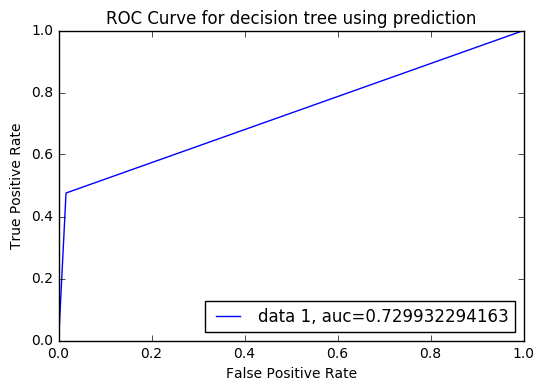

In [30]:
from sklearn import metrics as mt
import matplotlib.pyplot as plt

fpr, tpr, _ = mt.roc_curve(np.array(y_test_bool),  y_pred_bool)
auc = mt.roc_auc_score(np.array(y_test_bool), y_pred_bool)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for decision tree using prediction')
plt.legend(loc=4)
plt.show()

In [39]:
y_test_bool = y_test.apply(convert_bool)
y_pred_bool = convert_bool_arr(y_pred)

In [14]:
import numpy as np

In [40]:
params = list(perf_measure(np.array(y_test_bool),np.array(y_pred_bool)))
cal_fpr_acc(params[0],params[1],params[2],params[3])

(0.0168895831299424, 0.6698843340704201)

In [17]:
y_score

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

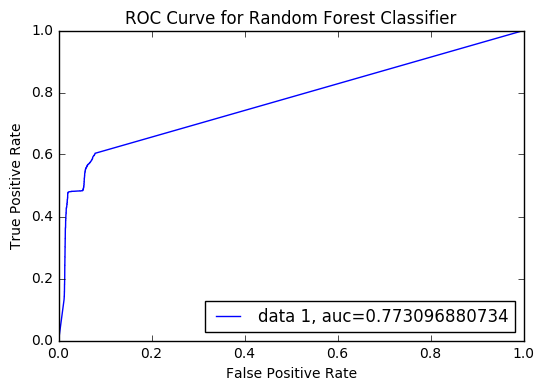

In [41]:
from sklearn import metrics as mt
import matplotlib.pyplot as plt

fpr, tpr, _ = mt.roc_curve(np.array(y_test_bool),  y_pred_prob)
auc = mt.roc_auc_score(np.array(y_test_bool), y_pred_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc=4)
plt.show()

In [24]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

     attack       0.92      0.62      0.74     13273
     normal       0.66      0.93      0.77     10243

avg / total       0.80      0.76      0.75     23516



In [19]:
y_test

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [16]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
y_train = lb_make.fit_transform(y_train)
y_test = lb_make.fit_transform(y_test)

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50, 2), random_state=1)

ImportError: cannot import name 'MLPClassifier'

In [5]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
#df_tot["protocol_type"] = lb_make.fit_transform(df_tot["protocol_type"])
#df_tot["service"] = lb_make.fit_transform(df_tot["service"])
#df_tot["flag"] = lb_make.fit_transform(df_tot["flag"])

df_tot = df_tot.drop(['protocol_type','service','flag'],axis=1)
df_tot.head(11)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,unknown1
1,0,491,0,0,0,0,0,0,0,0,...,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal
2,0,146,0,0,0,0,0,0,0,0,...,1,0.0,0.6,0.88,0.0,0.0,0.0,0.0,0.0,normal
3,0,0,0,0,0,0,0,0,0,0,...,26,0.1,0.05,0.0,0.0,1.0,1.0,0.0,0.0,dos
4,0,232,8153,0,0,0,0,0,1,0,...,255,1.0,0.0,0.03,0.04,0.03,0.01,0.0,0.01,normal
5,0,199,420,0,0,0,0,0,1,0,...,255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
6,0,0,0,0,0,0,0,0,0,0,...,19,0.07,0.07,0.0,0.0,0.0,0.0,1.0,1.0,dos
7,0,0,0,0,0,0,0,0,0,0,...,9,0.04,0.05,0.0,0.0,1.0,1.0,0.0,0.0,dos
8,0,0,0,0,0,0,0,0,0,0,...,15,0.06,0.07,0.0,0.0,1.0,1.0,0.0,0.0,dos
9,0,0,0,0,0,0,0,0,0,0,...,23,0.09,0.05,0.0,0.0,1.0,1.0,0.0,0.0,dos
10,0,0,0,0,0,0,0,0,0,0,...,13,0.05,0.06,0.0,0.0,1.0,1.0,0.0,0.0,dos


In [11]:
list(df_tot)

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'unknown1']

In [6]:
df_tr = df_tot.iloc[:125000]
df_ts = df_tot.iloc[125000:]

In [49]:
df_ts.shape

(23516, 39)

In [7]:
def bool_attack(x):
    if(x != "normal"):
        return "attack"
    else:
        return "normal"
    

In [8]:
df_tr_x = df_tr.drop('unknown1',axis = 1)
df_tr_y = df_tr['unknown1'].apply(bool_attack)
df_ts_x = df_ts.drop('unknown1',axis = 1)
df_ts_y = df_ts['unknown1'].apply(bool_attack)

In [9]:
from sklearn.preprocessing import Normalizer
normalise_tr = Normalizer().fit(df_tr_x)
df_tr_x = normalise_tr.transform(df_tr_x)

In [10]:
normalise_ts = Normalizer().fit(df_ts_x)
df_ts_x = normalise_tr.transform(df_ts_x)

In [17]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf.fit(df_tr_x,df_tr_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
df_ts_out = clf.predict(df_ts_x)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(df_ts_y,df_ts_out))

             precision    recall  f1-score   support

     attack       0.97      0.66      0.78     13273
     normal       0.69      0.98      0.81     10243

avg / total       0.85      0.79      0.79     23516



In [11]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(df_tr_x,df_tr_y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [12]:
df_ts_out = clf.predict(df_ts_x)

In [13]:
from sklearn.metrics import classification_report
print(classification_report(df_ts_y,df_ts_out))

             precision    recall  f1-score   support

     attack       0.95      0.62      0.75     13273
     normal       0.66      0.96      0.78     10243

avg / total       0.82      0.77      0.77     23516



In [14]:
from sklearn.svm import SVC
svc = SVC(gamma=2,C=1)
svc.fit(df_tr_x,df_tr_y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
df_ts_out = svc.predict(df_ts_x)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(df_ts_y,df_ts_out))

             precision    recall  f1-score   support

     attack       0.97      0.63      0.76     13273
     normal       0.67      0.97      0.79     10243

avg / total       0.84      0.78      0.78     23516



In [ ]:
df.to_csv('temp_tr.csv',index = False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df_tr = df.drop('unknown1',axis = 1)
clf = RandomForestClassifier(n_estimators=10)
clf.fit(df_tr,df['unknown1'])

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regr_3 = DecisionTreeRegressor(max_depth=8)
regr_3.fit(df_tr,df['unknown1'])

In [ ]:
df1 = pd.DataFrame()
df1 = pd.read_csv("test_proper_csv_attack_types.csv",header = None)
df1 = df1.rename(columns=df1.iloc[0])
df1 = df1.drop(df1.index[0])
df1 = df1.drop('unknown2',axis=1)
df1.to_csv('temp_ts.csv',index = False)